## Import Required Libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shutil


## Load the Dataset

In [2]:
# Load the datasets into pandas DataFrames
movies_df = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
ratings_df = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
tags_df = pd.read_csv('/kaggle/input/movielens-20m-dataset/tag.csv')

# Display the first few rows of each dataset to understand their structure
print("For movie: ")
print(movies_df.head())
print()
print("For ratings: ")
print(ratings_df.head())
print()
print("For Tags: ")
print(tags_df.head())

For movie: 
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

For ratings: 
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

For Tags: 
   userId  movieId            tag            timestamp
0      18     4141    M

## Data Understanding & Preprocessing

In [3]:
# Remove any missing values and duplicates
movies_df.dropna(inplace=True)
ratings_df.dropna(inplace=True)
tags_df.dropna(inplace=True)

# Remove duplicates if any
movies_df.drop_duplicates(inplace=True)
ratings_df.drop_duplicates(inplace=True)
tags_df.drop_duplicates(inplace=True)

# Preview the cleaned data
print(movies_df.head())
print(ratings_df.head())
print(tags_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      

## Exploratory Data Analysis 

In [4]:
# Get the shape of each dataset
print("Movies DataFrame Shape:", movies_df.shape)
print("Ratings DataFrame Shape:", ratings_df.shape)
print("Tags DataFrame Shape:", tags_df.shape)

Movies DataFrame Shape: (27278, 3)
Ratings DataFrame Shape: (20000263, 4)
Tags DataFrame Shape: (465548, 4)


In [5]:
# Get basic info (data types, non-null counts, etc.)
print("\nMovies DataFrame Info:")
print(movies_df.info())
print("\nRatings DataFrame Info:")
print(ratings_df.info())
print("\nTags DataFrame Info:")
print(tags_df.info())


Movies DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Ratings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Tags DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 465548 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465548 non-null  int64 
 1   movieId    465548 non-

In [6]:
# Check for missing values in each dataset
print("\nMissing Values in Movies DataFrame:")
print(movies_df.isnull().sum())

print("\nMissing Values in Ratings DataFrame:")
print(ratings_df.isnull().sum())

print("\nMissing Values in Tags DataFrame:")
print(tags_df.isnull().sum())


Missing Values in Movies DataFrame:
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings DataFrame:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing Values in Tags DataFrame:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



Ratings Descriptive Statistics:
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


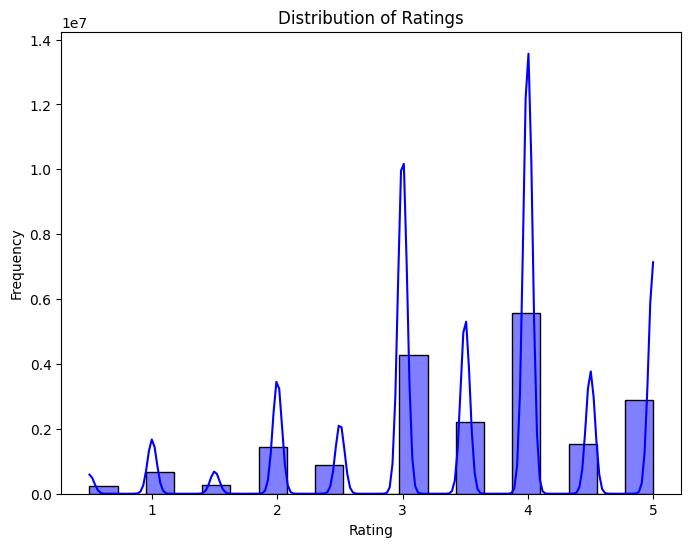

In [7]:
# Basic statistics for the ratings data
print("\nRatings Descriptive Statistics:")
print(ratings_df.describe())

# Plot the distribution of ratings
plt.figure(figsize=(8,6))
sns.histplot(ratings_df['rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Let's count how many genres each movie has
movies_df['genre_count'] = movies_df['genres'].apply(lambda x: len(x.split('|')))
print("\nMovies with the count of genres:")
print(movies_df['genre_count'].describe())


Movies with the count of genres:
count    27278.000000
mean         1.994501
std          1.038525
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: genre_count, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


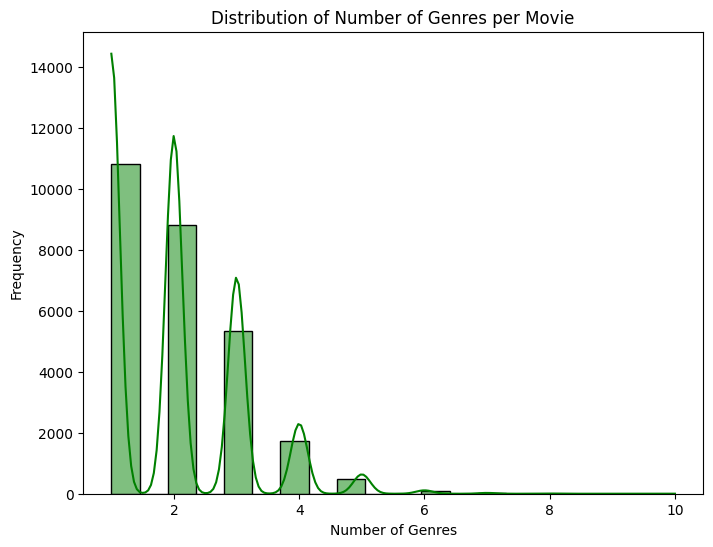

In [9]:
# Plot the distribution of genre counts
plt.figure(figsize=(8,6))
sns.histplot(movies_df['genre_count'], bins=20, kde=True, color='green')
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.show()

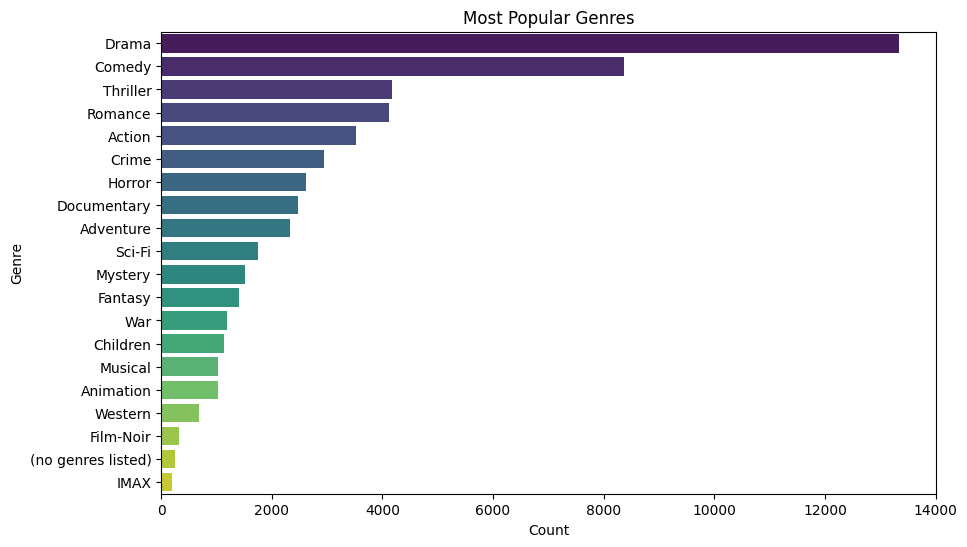

In [10]:
# Explore the most popular genres
genre_series = movies_df['genres'].str.split('|', expand=True).stack()
plt.figure(figsize=(10,6))
sns.countplot(y=genre_series, order=genre_series.value_counts().index, palette='viridis')
plt.title('Most Popular Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


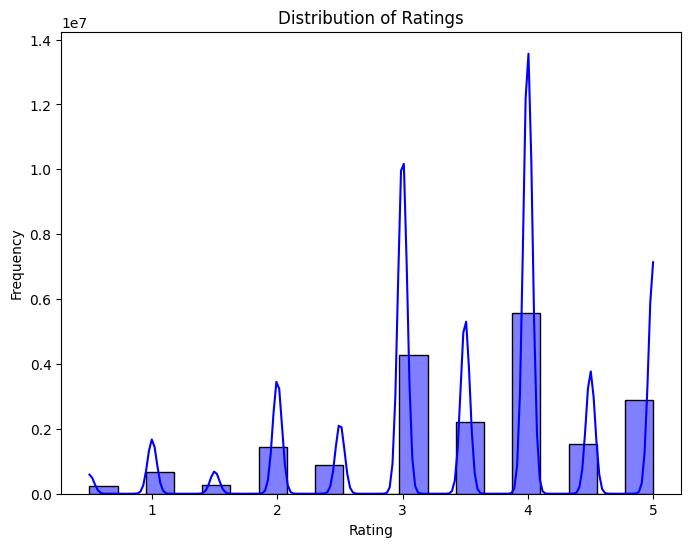

In [11]:
# Distribution of ratings
plt.figure(figsize=(8,6))
sns.histplot(ratings_df['rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


Rating Count per User (Top 10):
userId
1     175
2      61
3     187
4      28
5      66
6      24
7     276
8      70
9      35
10     38
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


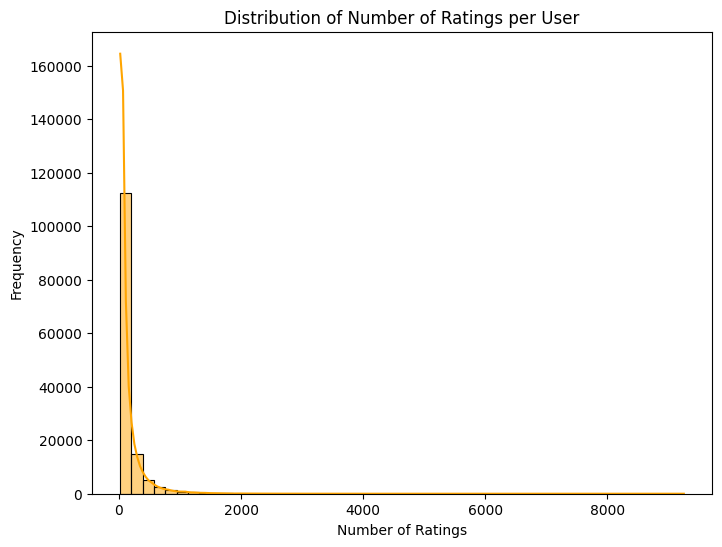

In [12]:
# Count the number of ratings per user
user_rating_counts = ratings_df.groupby('userId').size()
print("\nRating Count per User (Top 10):")
print(user_rating_counts.head(10))

# Plot the distribution of ratings per user
plt.figure(figsize=(8,6))
sns.histplot(user_rating_counts, bins=50, kde=True, color='orange')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


Rating Count per Movie (Top 10):
movieId
1     49695
2     22243
3     12735
4      2756
5     12161
6     23899
7     12961
8      1415
9      3960
10    29005
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


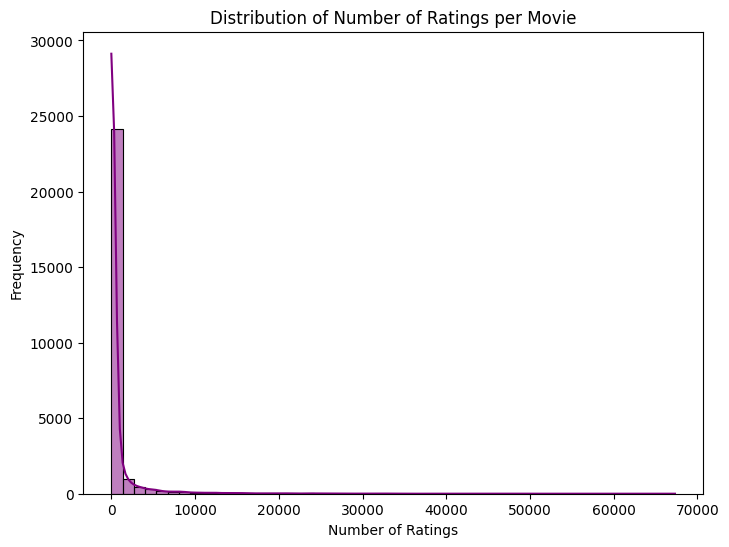

In [13]:
# Count the number of ratings per movie
movie_rating_counts = ratings_df.groupby('movieId').size()
print("\nRating Count per Movie (Top 10):")
print(movie_rating_counts.head(10))

# Plot the distribution of ratings per movie
plt.figure(figsize=(8,6))
sns.histplot(movie_rating_counts, bins=50, kde=True, color='purple')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


Tag Count per Movie (Top 10):
movieId
1     436
2     123
3      18
4       6
5      22
6     259
7      45
8       7
9       9
10     99
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


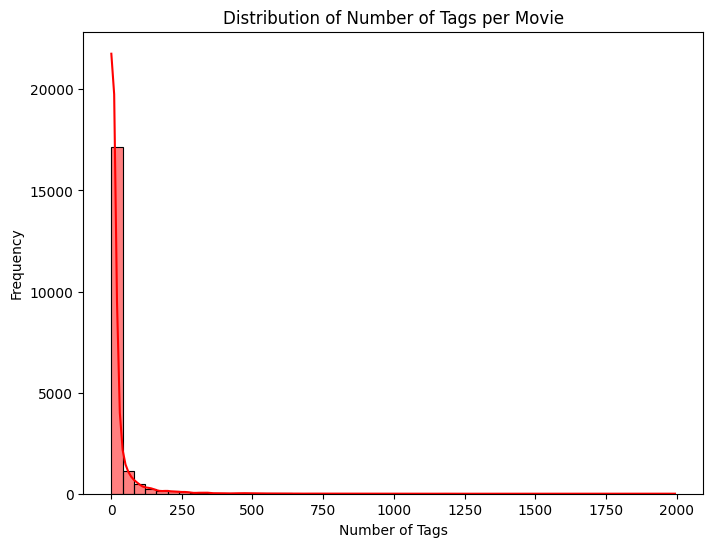

In [14]:
# Count the number of tags for each movie
tag_counts = tags_df.groupby('movieId').size()
print("\nTag Count per Movie (Top 10):")
print(tag_counts.head(10))

# Plot the distribution of tags per movie
plt.figure(figsize=(8,6))
sns.histplot(tag_counts, bins=50, kde=True, color='red')
plt.title('Distribution of Number of Tags per Movie')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()


Most Common Tags:
tag
sci-fi             3384
based on a book    3281
atmospheric        2917
comedy             2779
action             2657
surreal            2427
BD-R               2334
twist ending       2323
funny              2072
dystopia           1991
Name: count, dtype: int64


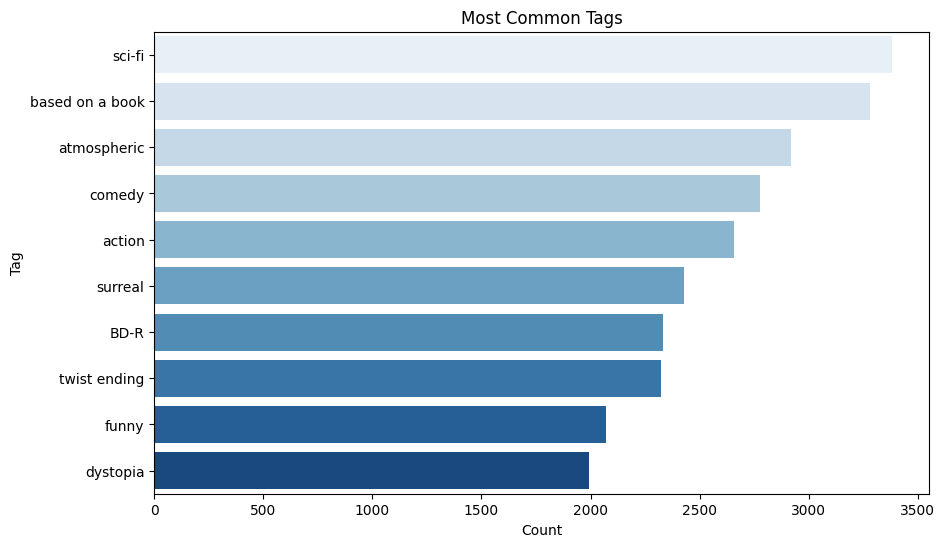

In [15]:
# Most common tags
tag_series = tags_df['tag'].value_counts().head(10)
print("\nMost Common Tags:")
print(tag_series)

# Plot the most common tags
plt.figure(figsize=(10,6))
sns.barplot(x=tag_series.values, y=tag_series.index, palette='Blues')
plt.title('Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


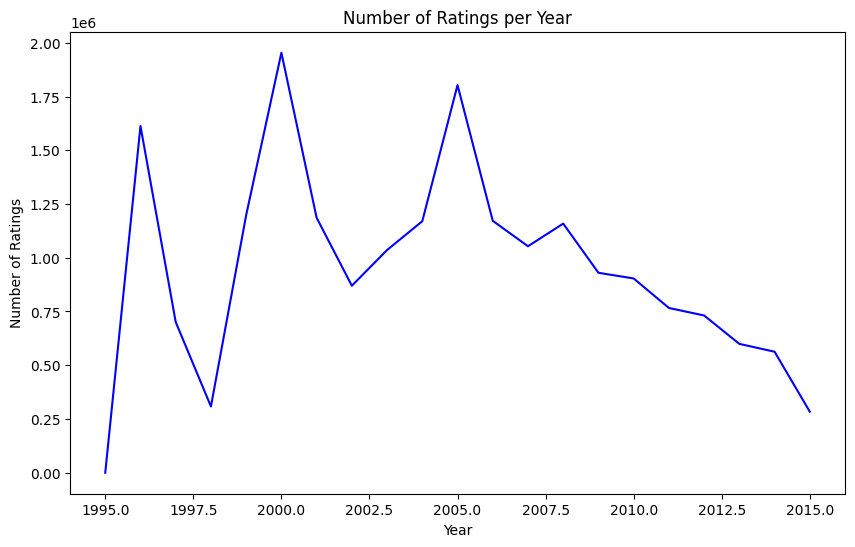

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


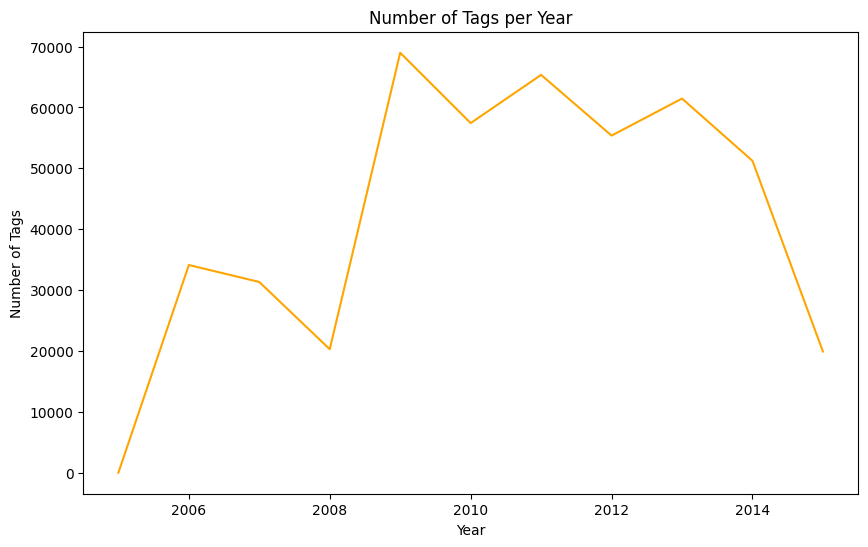

In [16]:
# Convert timestamp columns to datetime format
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'])

# Plot number of ratings over time
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_per_year = ratings_df.groupby('year').size()

plt.figure(figsize=(10,6))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values, color='blue')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

# Plot number of tags over time
tags_df['year'] = tags_df['timestamp'].dt.year
tags_per_year = tags_df.groupby('year').size()

plt.figure(figsize=(10,6))
sns.lineplot(x=tags_per_year.index, y=tags_per_year.values, color='orange')
plt.title('Number of Tags per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tags')
plt.show()

## Content-Based Filtering

In [17]:
# Combine genres and tags for each movie to create a single content-based description
tags_combined = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
tags_combined.columns = ['movieId', 'combined_tags']

In [18]:
# Merge with the original movies dataframe to create a combined description
movies_df = movies_df.merge(tags_combined, on='movieId', how='left')
movies_df['combined_content'] = movies_df['genres'] + ' ' + movies_df['combined_tags'].fillna('')

In [19]:
# Vectorize the combined content (genres + tags)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['combined_content'])


In [20]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [21]:
# Function to get recommendations based on movie title
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Get top 5 recommendations
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]


In [22]:
# Test content-based filtering function
print(get_recommendations("Toy Story (1995)"))

3027       Toy Story 2 (1999)
2270     Bug's Life, A (1998)
4790    Monsters, Inc. (2001)
5121           Ice Age (2002)
6271      Finding Nemo (2003)
Name: title, dtype: object


## Collaborative Filtering Using SVD

In [23]:
# Prepare the data for collaborative filtering using the Surprise library
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Apply the SVD algorithm
svd = SVD()
svd.fit(trainset)

In [24]:
# Make predictions on the testset
predictions = svd.test(testset)

In [25]:
# Evaluate the model using RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)
print(f'RMSE for Collaborative Filtering Model: {rmse}')

RMSE: 0.7855
RMSE for Collaborative Filtering Model: 0.7854872805366441


## Hybrid Recommendation Model  

In [26]:
# Hybrid Model combining content-based and collaborative filtering
def hybrid_recommendations(user_id, movie_title):
    # Get content-based recommendations
    content_recs = get_recommendations(movie_title)
    
    # Get collaborative filtering recommendations for unseen movies
    unseen_movies = ratings_df[~ratings_df['movieId'].isin(ratings_df[ratings_df['userId'] == user_id]['movieId'])]
    collab_recs = []
    for movie in unseen_movies['movieId']:
        prediction = svd.predict(user_id, movie)
        collab_recs.append((movie, prediction.est))
    
    # Sort collaborative recommendations by estimated rating
    collab_recs = sorted(collab_recs, key=lambda x: x[1], reverse=True)[:5]
    collab_movie_titles = movies_df[movies_df['movieId'].isin([rec[0] for rec in collab_recs])]['title'].tolist()
    
    # Combine content-based and collaborative-based recommendations
    combined_recs = list(set(content_recs + collab_movie_titles))
    return combined_recs[:5]

In [27]:
# Test hybrid recommendation for a user 
print(hybrid_recommendations(1, "Toy Story (1995)"))

["Bug's Life, A (1998)Avengers, The (2012)", 'Monsters, Inc. (2001)Avengers, The (2012)', 'Finding Nemo (2003)Avengers, The (2012)', 'Toy Story 2 (1999)Avengers, The (2012)', 'Ice Age (2002)Avengers, The (2012)']


## Model Evaluation

In [28]:
# Evaluate the hybrid model with some user input
user_id = 1
movie_title = "Toy Story (1995)"
hybrid_recs = hybrid_recommendations(user_id, movie_title)
print(f"Hybrid Recommendations for User {user_id} and Movie {movie_title}:")
print(hybrid_recs)

Hybrid Recommendations for User 1 and Movie Toy Story (1995):
["Bug's Life, A (1998)Avengers, The (2012)", 'Monsters, Inc. (2001)Avengers, The (2012)', 'Finding Nemo (2003)Avengers, The (2012)', 'Toy Story 2 (1999)Avengers, The (2012)', 'Ice Age (2002)Avengers, The (2012)']


## Saving the Model for Download for my Flask Application

In [29]:
# Save the SVD model
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the movies_df DataFrame (which includes the combined content used for recommendations)
movies_df.to_csv('movies_with_combined_content.csv', index=False)

print("Models and Data Saved Successfully!")

Models and Data Saved Successfully!


## To download the model

In [30]:
shutil.move("svd_model.pkl", "/kaggle/working/svd_model.pkl")
shutil.move("tfidf_vectorizer.pkl", "/kaggle/working/tfidf_vectorizer.pkl")
shutil.move("movies_with_combined_content.csv", "/kaggle/working/movies_with_combined_content.csv")

'/kaggle/working/movies_with_combined_content.csv'